This notebook estimates the curve shape relating a feature of interest (e.g. word surprisal) and average/peak amplitude for the given ERPs, given a trained Cannon model.

In [2]:
import io
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import torch
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
from berp.models import load_model
import berp.trainer  # good yaml defaults
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe, aggregate_cannon_coef_df

In [48]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"

paradigm = "cannon_wide"
cannon_run_name = "trf-berp-cannon_3quantiles.29720801"
# cannon_run_name = "trf-berp-cannon_4quantiles"
# cannon_run_name = "trf-cannon_10quantiles"

# Safe to load just one subject -- we only are investigating stimulus differences here
subjects = [1]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

# target_sensors = ["B19", "B20", "B22"]
target_sensors = ['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

temporal_rois = [("n125", 0.125 - 0.05, 0.125 + 0.05, "idxmin"),
                 ("n400", 0.35, 0.45, "idxmin")]
test_features = ["var_word_surprisal"]

# Only run quantitative tests on items we have a priori interest in. We want to avoid
# fishing for p-values here, and also degrading any positive results due to multiple
# comparisons.
# Semantics: (feature, troi, sensor) where we expect amplitude/latency-to-peak differences
a_priori_interest = [
    ("var_word_surprisal", "n125", "D19"),
    ("var_word_surprisal", "n125", "C10"),
    ("var_word_surprisal", "n400", "A19")
]

In [6]:
model_dir = f"../workflow/{workflow}/results_{paradigm}/{lm}/{cannon_run_name}"
dataset_dir = f"../workflow/{workflow}/data/dataset/{lm}"
stimulus_dir = f"../workflow/{workflow}/data/stimulus/{lm}"

## Prepare dataset

In [7]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
ds_paths = []
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue
    ds_paths.append(ds_path)
    
nested_ds = load_eeg_dataset(
    ds_paths,
    subset_sensors=target_sensors,
    stimulus_paths=stimulus_paths,
    normalize_X_ts=normalize_X_ts, 
    normalize_X_variable=normalize_X_variable, 
    normalize_Y=normalize_Y)

assert len(combs) == len(nested_ds.datasets)
ds = dict(zip(combs, nested_ds.datasets))

  0%|          | 0/19 [00:00<?, ?it/s]

## Load pipeline

In [8]:
pipe = load_model(model_dir, device="cpu")

In [9]:
yaml.safe_dump(pipe.get_params(), sys.stdout)

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=28096.5569715575, fit_intercept=True,\n   \
  \                    name='be53ad7337d94e7d9f4c6c05f8469081',\n                \
  \       optim=AdamSolver(n_batches=50,\n                                       \
  \ name='be53ad7337d94e7d9f4c6c05f8469081',\n                                   \
  \     random_state=RandomState(MT19937) at 0x2B540AEAE740),\n                  \
  \     sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 28096.5569715575
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: be53ad7337d94e7d9f4c6c05f8469081
encoder__optim: "AdamSolver(n_batches=50, name='be53ad7337d94e7d9f4c6c05f8469081',\n\
  \           random_state=RandomState(MT19937) at 0x2B540AEAE740)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: be53ad

## Prepare model estimates

### Get coefficients

In [10]:
coef_df = pipeline_to_dataframe(pipe)
coef_agg_df = aggregate_cannon_coef_df(coef_df, pipe)

In [11]:
coef_agg_df["sensor"] = coef_agg_df.sensor.map(dict(enumerate(target_sensors)))

### Compute Berp posterior

In [12]:
# Just analyze one subject per run -- there are no differences between subjects in this analysis
all_runs = {f"{story}/run{run}": ds for (story, subject, run), ds in ds.items()}

In [13]:
df = berp.viz.trf_em.get_cannon_posterior_df(pipe, all_runs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.53s/dataset]


In [14]:
df

recognition_quantile  word_length  \
dataset                   word_idx                                      
old-man-and-the-sea/run1  0                            1            3   
                          1                            1            2   
                          2                            2            3   
                          3                            2            3   
                          4                            0            2   
...                                                  ...          ...   
old-man-and-the-sea/run19 584                          2            4   
                          585                          1            2   
                          586                          0            2   
                          587                          0            2   
                          588                          2            7   

                                    word_duration  word_surprisal  \
dataset                   word_idx                                  
old-man-and-the-sea/run1  0              0.156250       -2.381337   
                          1              0.078125       -3.896170   
                          2              0.289062       -3.420624   
                          3              0.382812       -0.872183   
                          4              0.210938       -1.986570   
...                                           ...             ...   
old-man-and-the-sea/run19 584            0.250000       -4.542065   
                          585            0.156250       -1.088804   
                          586            0.109375       -0.945295   
                          587            0.117188       -2.847154   
                          588            0.632812       -3.234899   

                                    word_frequency  word_prior_entropy  \
dataset                   word_idx                                       
old-man-and-the-sea/run1  0              -0.644091            5.486012   
                          1              -0.306940            5.764207   
                          2               0.032988            6.296887   
                          3              -0.303927            4.189036   
                          4              -0.360423            3.307850   
...                                            ...                 ...   
old-man-and-the-sea/run19 584             0.723335            4.395442   
                          585            -0.399921            2.250363   
                          586            -1.006003            1.269512   
                          587            -0.780308            2.992393   
                          588             2.016655            3.286217   

                                       word  
dataset                   word_idx           
old-man-and-the-sea/run1  0             wʌz  
                          1              ʌn  
                          2            oʊld  
                          3             mæn  
                          4              hu  
...                                     ...  
old-man-and-the-sea/run19 584          lʊkt  
                          585            æt  
                          586            ɪt  
                          587            ɪn  
                          588       dɪsgʌst  

[10748 rows x 7 columns]

In [15]:
assert set(df.recognition_quantile) == set(coef_agg_df["quantile"])

## Draw tROIs

In [16]:
temporal_rois

[('n125', 0.075, 0.175, 'idxmin'), ('n400', 0.35, 0.45, 'idxmin')]

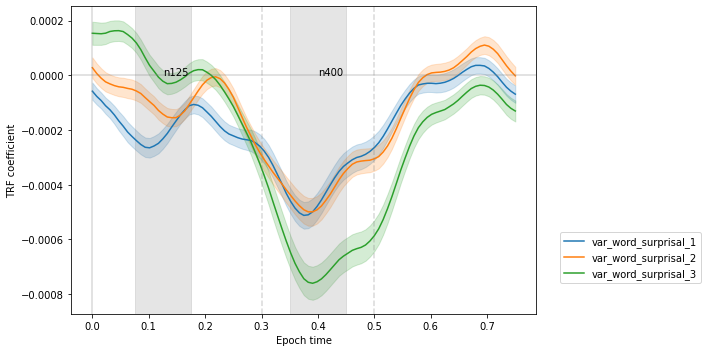

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
plot_trf_coefficients(coef_agg_df, errorbar="se", predictor_match_patterns=[test_features[0]], ax=ax)

for troi, tstart, tend, _ in temporal_rois:
    ax.axvspan(tstart, tend, alpha=0.2, color="gray")
    ax.text((tend + tstart) / 2, 0, troi)
    
None

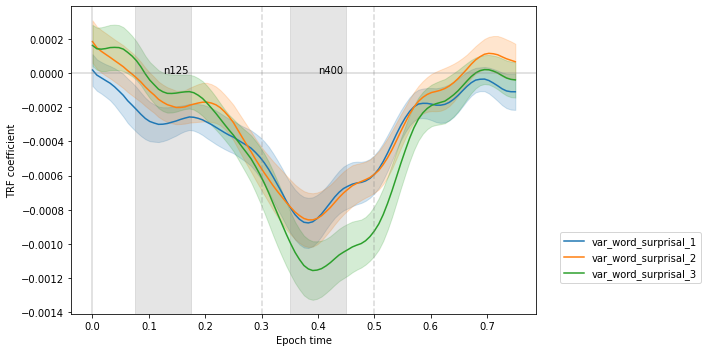

In [18]:
f, ax = plt.subplots(figsize=(10, 5))
plot_trf_coefficients(coef_agg_df[coef_agg_df.sensor == "A19"], errorbar="se", predictor_match_patterns=[test_features[0]], ax=ax)

for troi, tstart, tend, _ in temporal_rois:
    ax.axvspan(tstart, tend, alpha=0.2, color="gray")
    ax.text((tend + tstart) / 2, 0, troi)
    
None

## Visualize curves

In [19]:
surprisal_quantile_means = -df.groupby("recognition_quantile").word_surprisal.mean()
surprisal_quantile_means

recognition_quantile
0    1.337720
1    2.985122
2    4.867740
Name: word_surprisal, dtype: float32

In [20]:
df["word_probability"] = 2 ** df.word_surprisal
probability_quantile_means = df.groupby("recognition_quantile").word_probability.mean()
probability_quantile_means

recognition_quantile
0    0.552296
1    0.243671
2    0.119510
Name: word_probability, dtype: float32

In [21]:
roi_df = {}

for label, tstart, tend, agg in temporal_rois:
    sub_comb_df = coef_agg_df[coef_agg_df.epoch_time.between(tstart, tend)]
    roi_df[label] = sub_comb_df.loc[sub_comb_df.groupby(["subject", "sensor", "predictor_name", "quantile"]).coef.agg(agg)]
    
roi_df = pd.concat(roi_df, names=["toi"])
roi_df["mean_surprisal"] = roi_df["quantile"].map(surprisal_quantile_means)
roi_df["mean_probability"] = roi_df["quantile"].map(probability_quantile_means)
roi_df

base_predictor subject  lag  epoch_time sensor  quantile  \
toi                                                                            
n125 329     var_recognition_onset       1   10    0.078125    A19         0   
     330     var_recognition_onset       1   10    0.078125    A19         1   
     331     var_recognition_onset       1   10    0.078125    A19         2   
     59561      var_word_frequency       1   18    0.140625    A19         0   
     59594      var_word_frequency       1   19    0.148438    A19         1   
...                            ...     ...  ...         ...    ...       ...   
n400 116294     var_word_frequency       9   45    0.351562    D19         1   
     116295     var_word_frequency       9   45    0.351562    D19         2   
     175269     var_word_surprisal       9   45    0.351562    D19         0   
     175270     var_word_surprisal       9   45    0.351562    D19         1   
     175271     var_word_surprisal       9   45    0.351562    D19         2   

                 coef           predictor_name  mean_surprisal  \
toi                                                              
n125 329    -0.000173  var_recognition_onset_1        1.337720   
     330    -0.000164  var_recognition_onset_2        2.985122   
     331    -0.000152  var_recognition_onset_3        4.867740   
     59561  -0.000266     var_word_frequency_1        1.337720   
     59594  -0.000161     var_word_frequency_2        2.985122   
...               ...                      ...             ...   
n400 116294 -0.000751     var_word_frequency_2        2.985122   
     116295 -0.000733     var_word_frequency_3        4.867740   
     175269 -0.000945     var_word_surprisal_1        1.337720   
     175270 -0.000758     var_word_surprisal_2        2.985122   
     175271 -0.001510     var_word_surprisal_3        4.867740   

             mean_probability  
toi                            
n125 329             0.552296  
     330             0.243671  
     331             0.119510  
     59561           0.552296  
     59594           0.243671  
...                       ...  
n400 116294          0.243671  
     116295          0.119510  
     175269          0.552296  
     175270          0.243671  
     175271          0.119510  

[2736 rows x 10 columns]

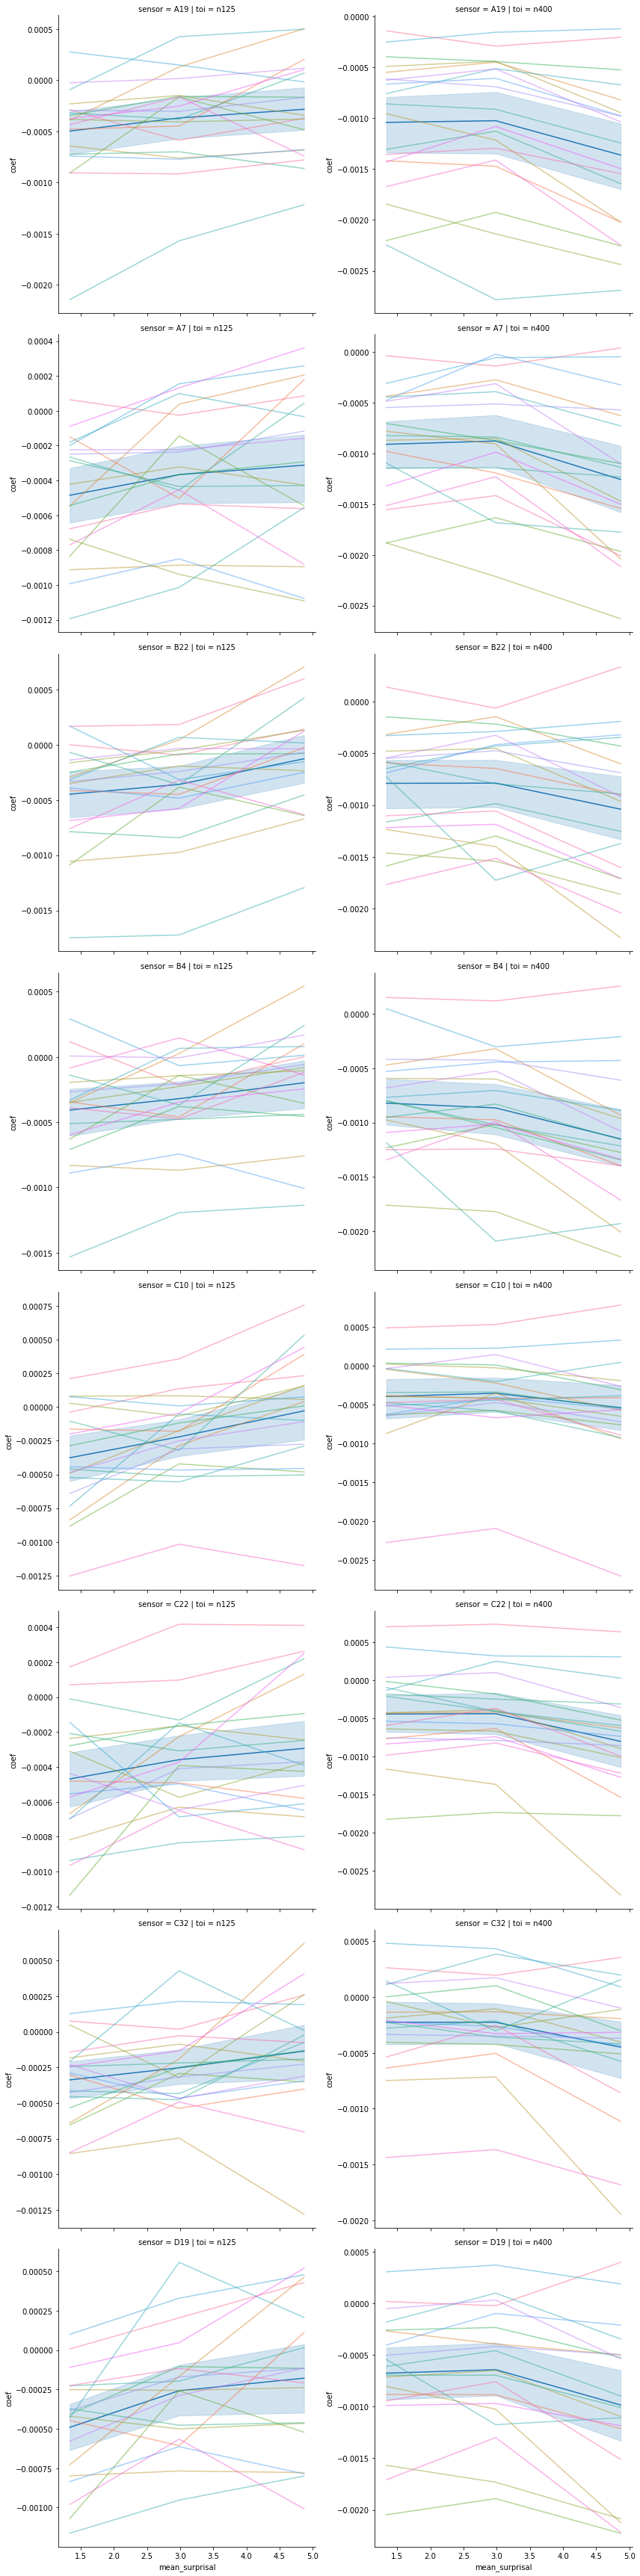

In [22]:
# g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
#                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), col="toi", row="sensor",
                  height=6, aspect=1, sharey=False)
g.map_dataframe(sns.lineplot, "mean_surprisal", "coef")
g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_surprisal", y="coef", hue="subject",
                                              alpha=0.5, errorbar=None))

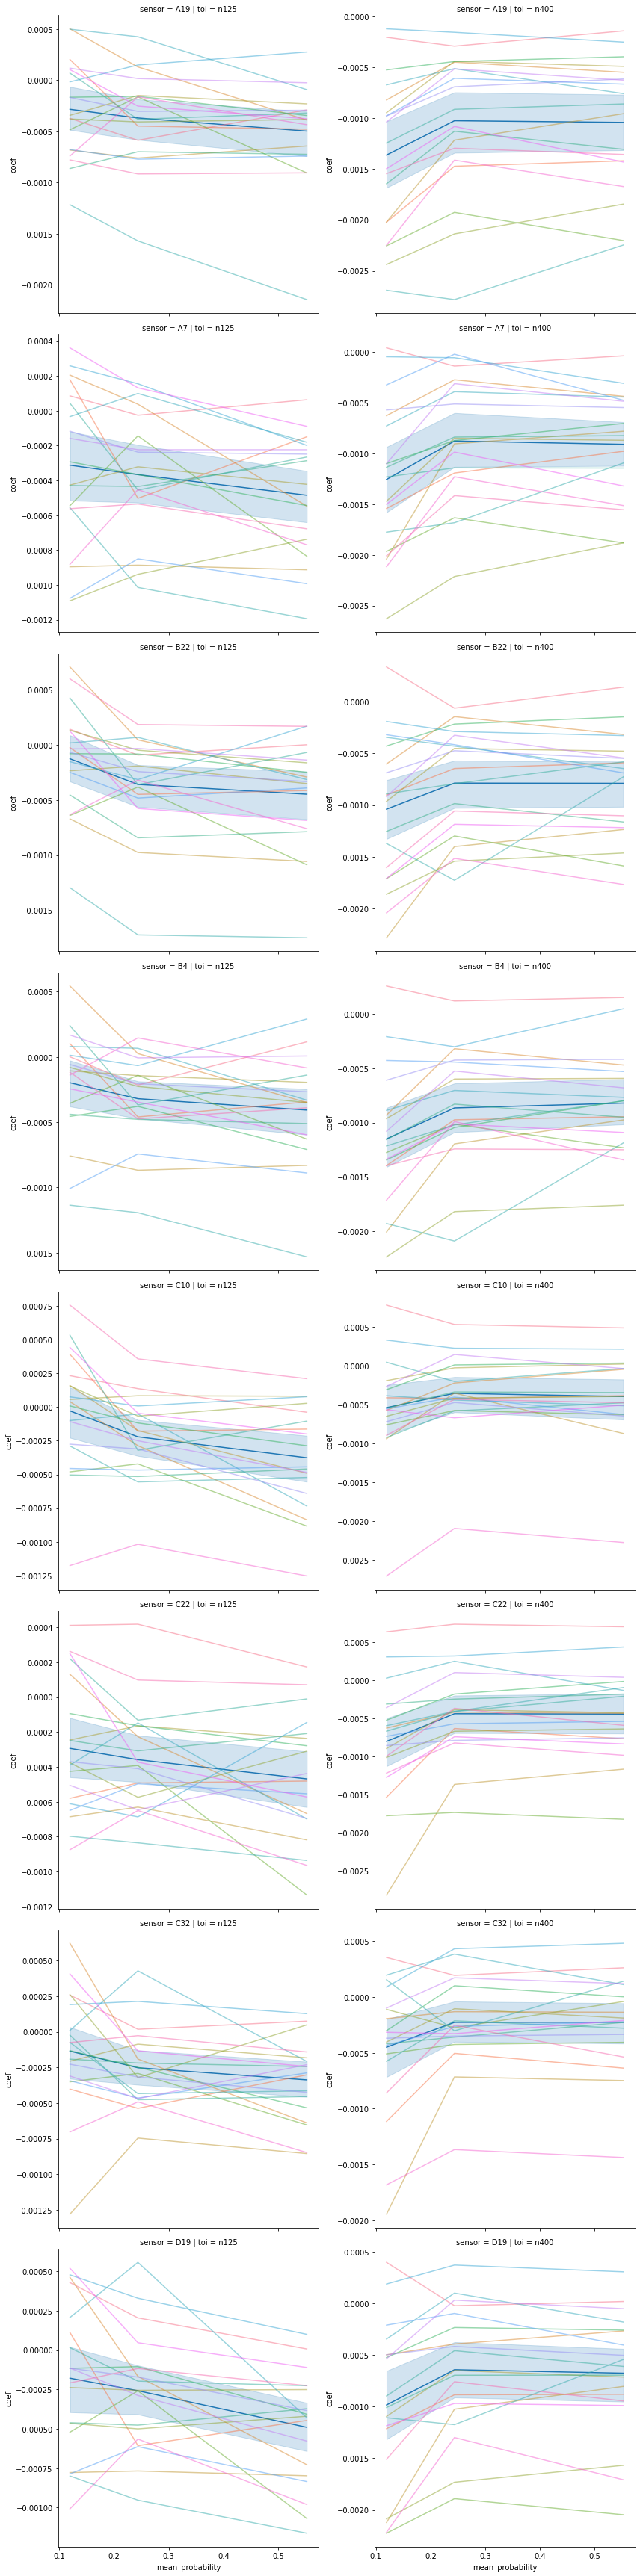

In [23]:
# g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
#                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), col="toi", row="sensor",
                  height=6, aspect=1, sharey=False)
g.map_dataframe(sns.lineplot, "mean_probability", "coef")
g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_probability", y="coef", hue="subject",
                                              alpha=0.5, errorbar=None))

## Quantitative test: regression

In [24]:
import statsmodels.api as sm

## Quantitative test: amplitude difference between peaks per quantile

In [25]:
test_df = roi_df.reset_index().set_index(["quantile", "base_predictor", "toi", "subject", "sensor"])
qmin, qmax = 0, roi_df["quantile"].max()
diff_df = test_df.loc[qmax].coef - test_df.loc[qmin].coef

In [26]:
test_df

level_1  lag  epoch_time  \
quantile base_predictor        toi  subject sensor                             
0        var_recognition_onset n125 1       A19         329   10    0.078125   
1        var_recognition_onset n125 1       A19         330   10    0.078125   
2        var_recognition_onset n125 1       A19         331   10    0.078125   
0        var_word_frequency    n125 1       A19       59561   18    0.140625   
1        var_word_frequency    n125 1       A19       59594   19    0.148438   
...                                                     ...  ...         ...   
                               n400 9       D19      116294   45    0.351562   
2        var_word_frequency    n400 9       D19      116295   45    0.351562   
0        var_word_surprisal    n400 9       D19      175269   45    0.351562   
1        var_word_surprisal    n400 9       D19      175270   45    0.351562   
2        var_word_surprisal    n400 9       D19      175271   45    0.351562   

                                                        coef  \
quantile base_predictor        toi  subject sensor             
0        var_recognition_onset n125 1       A19    -0.000173   
1        var_recognition_onset n125 1       A19    -0.000164   
2        var_recognition_onset n125 1       A19    -0.000152   
0        var_word_frequency    n125 1       A19    -0.000266   
1        var_word_frequency    n125 1       A19    -0.000161   
...                                                      ...   
                               n400 9       D19    -0.000751   
2        var_word_frequency    n400 9       D19    -0.000733   
0        var_word_surprisal    n400 9       D19    -0.000945   
1        var_word_surprisal    n400 9       D19    -0.000758   
2        var_word_surprisal    n400 9       D19    -0.001510   

                                                             predictor_name  \
quantile base_predictor        toi  subject sensor                            
0        var_recognition_onset n125 1       A19     var_recognition_onset_1   
1        var_recognition_onset n125 1       A19     var_recognition_onset_2   
2        var_recognition_onset n125 1       A19     var_recognition_onset_3   
0        var_word_frequency    n125 1       A19        var_word_frequency_1   
1        var_word_frequency    n125 1       A19        var_word_frequency_2   
...                                                                     ...   
                               n400 9       D19        var_word_frequency_2   
2        var_word_frequency    n400 9       D19        var_word_frequency_3   
0        var_word_surprisal    n400 9       D19        var_word_surprisal_1   
1        var_word_surprisal    n400 9       D19        var_word_surprisal_2   
2        var_word_surprisal    n400 9       D19        var_word_surprisal_3   

                                                    mean_surprisal  \
quantile base_predictor        toi  subject sensor                   
0        var_recognition_onset n125 1       A19           1.337720   
1        var_recognition_onset n125 1       A19           2.985122   
2        var_recognition_onset n125 1       A19           4.867740   
0        var_word_frequency    n125 1       A19           1.337720   
1        var_word_frequency    n125 1       A19           2.985122   
...                                                            ...   
                               n400 9       D19           2.985122   
2        var_word_frequency    n400 9       D19           4.867740   
0        var_word_surprisal    n400 9       D19           1.337720   
1        var_word_surprisal    n400 9       D19           2.985122   
2        var_word_surprisal    n400 9       D19           4.867740   

                                                    mean_probability  
quantile base_predictor        toi  subject sensor                    
0        var_recognition_onset n125 1       A19             0.552296  
1        var_recognition_o

In [27]:
diff_df

base_predictor         toi   subject  sensor
var_recognition_onset  n125  1        A19       0.000021
var_word_frequency     n125  1        A19       0.000022
var_word_surprisal     n125  1        A19      -0.000083
var_recognition_onset  n125  1        A7       -0.000056
var_word_frequency     n125  1        A7       -0.000049
                                                  ...   
                       n400  9        C32      -0.000054
var_word_surprisal     n400  9        C32      -0.000321
var_recognition_onset  n400  9        D19      -0.000345
var_word_frequency     n400  9        D19       0.000034
var_word_surprisal     n400  9        D19      -0.000565
Name: coef, Length: 912, dtype: float32

### Bootstrap evaluation

In [28]:
diff_df.loc["var_word_surprisal"] \
    .groupby(["toi", "sensor"]).apply(lambda rows: np.quantile(sns.algorithms.bootstrap(rows.values), (.025, 0.975)))

toi   sensor
n125  A19         [5.624702380373492e-05, 0.00037773232907056803]
      A7           [5.255430714896648e-05, 0.0002962779501103796]
      B22         [0.00020061353643541224, 0.0004475813184399158]
      B4            [9.60231373028364e-05, 0.0003269086002546827]
      C10         [0.0002255794417578727, 0.00046869529105606487]
      C22           [3.8781142757216e-05, 0.00031957133905962087]
      C32          [5.876778341189493e-05, 0.0003613908076658844]
      D19          [0.0001793834650015924, 0.0004615985119016841]
n400  A19        [-0.0004533341314527206, -0.0002026691545324866]
      A7        [-0.0005083721305709332, -0.00019340599501447295]
      B22       [-0.0004039855906739831, -0.00010134815202036413]
      B4        [-0.00045534526943811213, -0.00021409564469649...
      C10         [-0.00024237392572104, -4.4552953750098886e-05]
      C22       [-0.0005407045711763204, -0.00020812271977774802]
      C32       [-0.00035909760990762154, -0.00011692975258483.

In [29]:
bootstrap_df = diff_df.loc["var_word_surprisal"] \
    .groupby(["sensor", "toi"]).apply(lambda rows: pd.Series(sns.algorithms.bootstrap(rows.values))).droplevel(-1).reset_index()

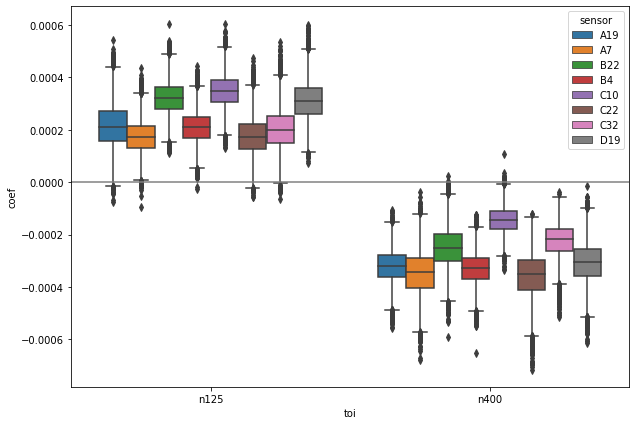

In [30]:
f, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=bootstrap_df, x="toi", y="coef", hue="sensor", ax=ax)
ax.axhline(0, color="gray")

### t-test

In [31]:
diff_df.groupby(["base_predictor", "toi"]).apply(lambda xs: st.ttest_1samp(xs, 0)).sort_values()

base_predictor         toi 
var_word_surprisal     n400    (-11.039889546812603, 3.804523462490489e-21)
var_word_frequency     n400       (-8.443068110706, 2.3651096056563284e-14)
var_recognition_onset  n400     (-4.660940089056291, 6.864412332499525e-06)
                       n125       (-1.2421872645487118, 0.2160932489922622)
var_word_frequency     n125      (4.578791187624348, 9.709314201056267e-06)
var_word_surprisal     n125      (9.69821801104842, 1.3757202334106578e-17)
Name: coef, dtype: object

In [32]:
ptests = diff_df.groupby(["base_predictor", "toi", "sensor"]).apply(lambda xs: st.ttest_1samp(xs, 0))

In [49]:
# Peek ONLY at the cases which we selected from the clustering analysis.
ptests.loc[a_priori_interest]

base_predictor      toi   sensor
var_word_surprisal  n125  D19        (4.212755313931063, 0.0005231839117223286)
                          C10       (5.442049475870561, 3.6030820316757886e-05)
                    n400  A19       (-4.928707378283017, 0.0001083571622956454)
Name: coef, dtype: object

## Quantitative test: latency-to-peak difference per quantile

In [93]:
latency_df = roi_df.reset_index().set_index(["base_predictor", "toi", "sensor", "quantile", "subject"]).sort_index()

In [94]:
# Get just the tROIs+sensors+features of interest
latency_df = pd.concat({
    quantile: pd.concat(
        [latency_df.loc[(predictor, toi, sensor, quantile)] for predictor, toi, sensor in a_priori_interest],
        names=["predictor", "toi", "sensor", "subject"], keys=a_priori_interest).sort_index()
    for quantile in [qmin, qmax]
}, names=["quantile"])
latency_df

level_1  lag  epoch_time  \
quantile predictor          toi  sensor subject                             
0        var_word_surprisal n125 C10    1         118353   12    0.093750   
                                        10        121393   10    0.078125   
                                        11        124657   15    0.117188   
                                        12        127601   10    0.078125   
                                        13        131089   22    0.171875   
...                                                  ...  ...         ...   
2        var_word_surprisal n400 A19    5         163243   57    0.445312   
                                        6         166219   53    0.414062   
                                        7         169227   50    0.390625   
                                        8         172363   51    0.398438   
                                        9         175275   45    0.351562   

                                                     coef  \
quantile predictor          toi  sensor subject             
0        var_word_surprisal n125 C10    1       -0.000039   
                                        10      -0.000164   
                                        11      -0.000837   
                                        12      -0.000492   
                                        13       0.000080   
...                                                   ...   
2        var_word_surprisal n400 A19    5       -0.000978   
                                        6       -0.001036   
                                        7       -0.001496   
                                        8       -0.002247   
                                        9       -0.001544   

                                                       predictor_name  \
quantile predictor          toi  sensor subject                         
0        var_word_surprisal n125 C10    1        var_word_surprisal_1   
                                        10       var_word_surprisal_1   
                                        11       var_word_surprisal_1   
                                        12       var_word_surprisal_1   
                                        13       var_word_surprisal_1   
...                                                               ...   
2        var_word_surprisal n400 A19    5        var_word_surprisal_3   
                                        6        var_word_surprisal_3   
                                        7        var_word_surprisal_3   
                                        8        var_word_surprisal_3   
                                        9        var_word_surprisal_3   

                                                 mean_surprisal  \
quantile predictor          toi  sensor subject                   
0        var_word_surprisal n125 C10    1               1.33772   
                                        10              1.33772   
                                        11              1.33772   
                                        12              1.33772   
                                        13              1.33772   
...                                                         ...   
2        var_word_surprisal n400 A19    5               4.86774   
                                        6               4.86774   
                                        7               4.86774   
                                        8               4.86774   
                                        9               4.86774   

                                                 mean_probability  
quantile predictor          toi  sensor subject                    
0        var_word_surprisal n125 C10    1                0.552296  
                                        10               0.552296  
                                        11               0.552296  
                                        12               0.552296  
                       

In [96]:
latency_diff_df = latency_df.loc[qmax].lag - latency_df.loc[qmin].lag
latency_diff_df.head()

predictor           toi   sensor  subject
var_word_surprisal  n125  C10     1          -2
                                  10         12
                                  11          1
                                  12         12
                                  13          0
Name: lag, dtype: int64

In [101]:
latency_diff_plot_df = latency_diff_df.reset_index()
latency_diff_plot_df["label"] = latency_diff_plot_df.predictor.str.cat([latency_diff_plot_df.toi, latency_diff_plot_df.sensor], sep=" ")

In [102]:
latency_diff_plot_df

,predictor,toi,sensor,subject,lag,label
0,var_word_surprisal,n125,C10,1,-2,var_word_surprisal n125 C10
1,var_word_surprisal,n125,C10,10,12,var_word_surprisal n125 C10
2,var_word_surprisal,n125,C10,11,1,var_word_surprisal n125 C10
3,var_word_surprisal,n125,C10,12,12,var_word_surprisal n125 C10
4,var_word_surprisal,n125,C10,13,0,var_word_surprisal n125 C10
5,var_word_surprisal,n125,C10,14,12,var_word_surprisal n125 C10
6,var_word_surprisal,n125,C10,15,-2,var_word_surprisal n125 C10
7,var_word_surprisal,n125,C10,16,2,var_word_surprisal n125 C10
8,var_word_surprisal,n125,C10,17,3,var_word_surprisal n125 C10
9,var_word_surprisal,n125,C10,18,-2,var_word_surprisal n125 C10


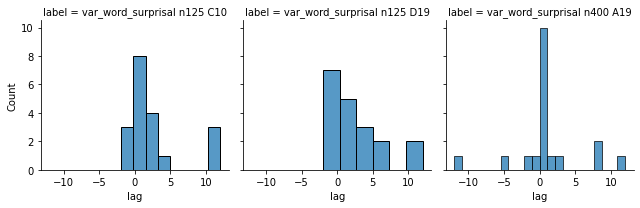

In [104]:
g = sns.FacetGrid(data=latency_diff_plot_df, col="label", col_wrap=3)
g.map(sns.histplot, "lag")

In [107]:
latency_diff_df.groupby(["predictor", "toi", "sensor"]).apply(
    lambda toi_rows: st.ttest_1samp(toi_rows, popmean=0))

predictor           toi   sensor
var_word_surprisal  n125  C10       (2.2575377095559475, 0.03663594867061983)
                          D19       (3.0753463803927366, 0.00652146469347338)
                    n400  A19        (0.6425895644302099, 0.5285912731838153)
Name: lag, dtype: object